In [1]:
import numpy as np
DTYPE = np.float64
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
import pickle
import gzip
from tqdm import tqdm
try:
    import flory
    
except ImportError:
    print("Installing 'flory' temporarily...")
    !pip install flory --quiet
    import flory

from numba import jit

In [2]:
# Global concentrations
phi_global = np.array([0.3, 0.3, 0.4], dtype = DTYPE)

# For phi grid
step_size = 0.001
n_points = 100

Xs = np.arange(0, 0.3, 0.1)

tol = DTYPE(1e-4)

In [3]:
# Flory Huggins Free Energy function
def floryHuggins(phi:DTYPE, chi:np.array):
    part_1 = np.sum(phi*np.log(phi))
    part_2 = 0

    for i in range(len(phi)):
        for j in range(i+1, len(phi)):
            part_2 += chi[i][j]*phi[i]*phi[j]

    return part_1 + part_2

In [4]:
# General Function for computing mergers of compartments
# Returns the concentrations of components in the merged and the unmerged compartments
# Stores them in phi_in_kmerged and phi_in_kunmerged respectively.


def mergers(concs:np.array, vols:np.array, chis, merged_compartments:list):
    # Find the unmerged compartment(s)
    expected = len(vols)*(len(vols)+1)//2
    actual = np.sum(merged_compartments)
    unmerged_compartment = expected - actual

    # print(concs)
    # print(vols)
    # print(unmerged)

    # Compute the merged volumes, stored in variable eta_merged
    # subtract -1 from the merged_compartments idxs to maintain python idxing
    eta_merged = 0
    for compartment in merged_compartments:
        eta_merged += vols[compartment-1]
    # print(eta_merged)

    # Calculating the compositions of components in the merged compartment
    # Taking a simple weighted average
    phi_1merged = (vols[merged_compartments[0]-1]*concs[0, merged_compartments[0]-1] + vols[merged_compartments[1]-1]*concs[0, merged_compartments[1]-1])/eta_merged
    phi_2merged = (vols[merged_compartments[0]-1]*concs[1, merged_compartments[0]-1] + vols[merged_compartments[1]-1]*concs[1, merged_compartments[1]-1])/eta_merged
    phi_3merged = 1 - phi_1merged - phi_2merged
    # print(phi_1merged, phi_2merged, phi_3merged)
    # print(phi_1merged + phi_2merged + phi_3merged)

    phi_in_kmerged = [phi_1merged, phi_2merged, phi_3merged]
    phi_in_kunmerged = [concs[0, unmerged_compartment-1], concs[1, unmerged_compartment-1], concs[2, unmerged_compartment-1]]
    # print(phi_in_kmerged)
    # print(phi_in_kunmerged)

    F_merged = eta_merged*floryHuggins(phi_in_kmerged, chis) + vols[unmerged_compartment-1]*floryHuggins(phi_in_kunmerged, chis)
    # print(F_merged)

    return phi_in_kunmerged, phi_in_kmerged, eta_merged, unmerged_compartment

    

In [5]:
# Perturbs the initial guess
# Calculates free energy in slcies of eta_merged_perturbed for (phi_1merged, phi_2merged) per slice

def perturb_mergers(concs, vols, chis, phi_in_kunmerged, phi_in_kmerged, eta_merged, merged_compartments, unmerged_compartment, step_size: float, n_points: int):
    phi_1merged_perturbed = np.linspace(max(tol, phi_in_kmerged[0] - n_points*step_size), min(1-tol, phi_in_kmerged[0] + n_points*step_size), 2*n_points+1)
    phi_2merged_perturbed = np.linspace(max(tol, phi_in_kmerged[1] - n_points*step_size), min(1-tol, phi_in_kmerged[1] + n_points*step_size), 2*n_points+1)
    eta_merged_perturbed = np.linspace(max(tol, eta_merged - n_points*step_size), min(1-tol, eta_merged + n_points*step_size), 2*n_points+1)
    
    phi_1global = phi_global[0]
    phi_2global = phi_global[1]

    for eta_m in eta_merged_perturbed:
        if eta_m<0 or eta_m>1:
            continue
        eta_unmerged = 1 - eta_m # volume of the unmerged compartment

        accepted_phi_1merged = []
        accepted_phi_2merged = []
        accepted_Fs = []
        
        for phi_1m in phi_1merged_perturbed:
            for phi_2m in phi_2merged_perturbed:
                # concentrations in the unmerged compartments
                phi_1unmerged = (phi_1global - eta_m*phi_1m)/eta_unmerged
                phi_2unmerged = (phi_2global - eta_m*phi_2m)/eta_unmerged
                
                if phi_1unmerged<0 or phi_1unmerged>1 or phi_2unmerged<0 or phi_2unmerged>1:
                    continue  
                    

                phi_3m = 1 - phi_1m - phi_2m
                phi_3unmerged = 1 - phi_1unmerged - phi_2unmerged

                if phi_3m<0 or phi_3m>1 or phi_3unmerged<0 or phi_3unmerged>1:
                    continue
                
                phi_in_kmerged = [phi_1m, phi_2m, phi_3m]
                phi_in_kunmerged =  [phi_1unmerged, phi_2unmerged, phi_3unmerged]

                # Compute the free energy for the perturbed configurations for eta_m as the merger volume
                F = eta_m*floryHuggins(phi_in_kmerged, chis) + eta_unmerged*floryHuggins(phi_in_kunmerged, chis)

                accepted_phi_1merged.append(phi_1m)
                accepted_phi_2merged.append(phi_2m)
                accepted_Fs.append(F)
                
        output_filepath = f"data/withVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/mergers/{merged_compartments}/volume_slices/"
        output_filename = f"eta_m{eta_m:.3f}.pkl"
        if not os.path.exists(output_filepath):
            os.makedirs(output_filepath)
        output_file = os.path.join(output_filepath, output_filename)
        data_to_save = {
            "eta_merged": eta_m,
            "phi_1merged": accepted_phi_1merged,
            "phi_2merged": accepted_phi_2merged,
            "F": accepted_Fs,
            "metadata": {
                "merged_compartments": merged_compartments,  # Which compartments were merged
                "unmerged_compartment": unmerged_compartment,  # The remaining compartment
                "initial_merged_concentration_guess": [phi_in_kmerged[0], phi_in_kmerged[1]] # initial guesses of the concentrations in the merged compartment. i.e. the values around which the perturbations take place.
            }
        }
        with gzip.open(output_file, "wb") as f:
            pickle.dump(data_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)


In [60]:
# Plotting contours for the best slices and the best merger
def plot_Contours(Xs):
    for X in (Xs):
        merged_compartments_list = [np.array([1, 2], dtype=np.int64), np.array([2, 3], dtype=np.int64), np.array([1, 3], dtype=np.int64)]
        # merged_compartments_list = [np.array([1, 2], dtype=np.int64)]
    
        # Load the best merger
        input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/analysis/X{X:.3f}/mergers/"
        input_filename = f"best_merger.pkl"
        input_file = os.path.join(input_filepath, input_filename)
        with gzip.open(input_file, "rb") as f:
            loaded_data_best = pickle.load(f)
            
        # LOAD the best slice
        for idx, merged_compartments in enumerate(merged_compartments_list):
            # Get the best slice for each merger
            input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/analysis/X{X:.3f}/mergers/{merged_compartments}/best_volume_slice/"
            input_filename = f"best_slice.pkl"
            input_file = os.path.join(input_filepath, input_filename)
            with gzip.open(input_file, 'rb') as f:
                loaded_data = pickle.load(f)
            best_slice = loaded_data["best_slice"]
    
    
            # Now, LOAD the phi data
            input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/mergers/{merged_compartments}/volume_slices/"
            input_filename = f"eta_m{best_slice:.3f}.pkl"
            input_file = os.path.join(input_filepath, input_filename)
            
            with gzip.open(input_file, "rb") as f:
                loaded_data = pickle.load(f)
            # print(loaded_data["metadata"])
    
            # PLOT a contour for this loaded data
            phi1_grid = np.linspace(min(loaded_data["phi_1merged"]), max(loaded_data["phi_1merged"]), 100)
            phi2_grid = np.linspace(min(loaded_data["phi_2merged"]), max(loaded_data["phi_2merged"]), 100)
            phi1_mesh, phi2_mesh = np.meshgrid(phi1_grid, phi2_grid)
    
            # Interpolate F values onto the grid
            F_grid = griddata(
                (loaded_data["phi_1merged"], loaded_data["phi_2merged"]), 
                loaded_data["F"], 
                (phi1_mesh, phi2_mesh), 
                method='cubic'
            )
    
            # Create the contour plot
            fig, ax = plt.subplots(figsize=(8, 6))
            contour = plt.contourf(phi1_mesh, phi2_mesh, F_grid, levels=1000, cmap = "RdYlBu_r")
            plt.colorbar(contour, label=r'$F\, (k_BT)$')
    
            # Mark the minimum value of F
            min_F_index = np.argmin(loaded_data["F"])
            min_phi1 = loaded_data["phi_1merged"][min_F_index]
            min_phi2 = loaded_data["phi_2merged"][min_F_index]
            min_F = loaded_data["F"][min_F_index]
    
            label = r"($\phi_{1, \text{merged}}^{\text{best}}, \phi_{2, \text{merged}}^{\text{best}}) =$" + f"({min_phi1:.3f}, {min_phi2:.3f})"
            ax.scatter(
                min_phi1, min_phi2, 
                color='lightgreen', 
                s=50,
                marker = ".",
                linewidth=0.5,
                label=label
            )
            
            # Add contour lines
            CS = plt.contour(phi1_mesh, phi2_mesh, F_grid, levels=40, colors='k', linewidths=0.25)
            
            phi1_d = phi1_grid[1]-phi1_grid[0]
            phi2_d = phi2_grid[1]-phi2_grid[0]
            ax.set_xlim([phi1_grid[0]-5*phi1_d, phi1_grid[-1]+5*phi1_d])
            ax.set_ylim([phi2_grid[0]-5*phi2_d, phi2_grid[-1]+5*phi2_d])
            
            
            ax.set_xlabel(r'$\phi_{1, \text{merged}}$', fontsize=12)
            ax.set_ylabel(r'$\phi_{2, \text{merged}}$', fontsize=12)
        
            title = f"X = {X:.3f}" + "\n" + r"$\Phi^{\text{global}}=$" + f"{phi_global}" +"\n" + f'Merged compartments: {loaded_data["metadata"]["merged_compartments"]}' + "\n" + r"$\eta^{\text{merged}}=$" + f"{best_slice:.3f}"
            plt.title(title)
    
            
            phi1_guess = loaded_data["metadata"]["initial_merged_concentration_guess"][0]
            phi2_guess = loaded_data["metadata"]["initial_merged_concentration_guess"][1]
            suptitle = r"($\phi_{1, \text{merged}}^{in}, \phi_{2, \text{merged}}^{in}) =$" + f"({phi1_guess:.3f}, {phi2_guess:.3f})"
            fig.suptitle(suptitle)
            
            plt.legend(loc = "lower left")
            
            fig.tight_layout()
            # print(best_slice)
            output_filepath = f"data/withVolFluctuations/phi_g{phi_global}/analysis/X{X:.3f}/mergers/{merged_compartments}/best_volume_slice/"
            output_filename = f"contour.png"
            if not os.path.exists(output_filepath):
                os.makedirs(output_filepath)
            output_file = os.path.join(output_filepath, output_filename)
            
            plt.savefig(output_file, dpi=400)
            # plt.close()
    
            if np.array_equal(merged_compartments, loaded_data_best["best_merger_compartment"]):
                output_filepath = f"data/withVolFluctuations/phi_g{phi_global}/analysis/X{X:.3f}/mergers/"
                output_filename = f"best_merger_contour.png"
                if not os.path.exists(output_filepath):
                    os.makedirs(output_filepath)
                output_file = os.path.join(output_filepath, output_filename)
                
                plt.savefig(output_file, dpi=400)
            plt.close()

In [8]:
# Plot the Euclidean distance between the guest and the best as a function of X
def plot_XvsD(Xs):
    ds = []
    for X in tqdm(Xs):
        # Get the best merger
        input_filepath = f"data/noVolFluctuations/phi_g{phi_global}/analysis/X{X:.3f}"
        input_filename = f"best_merger.pkl"
        if not os.path.exists(input_filepath):
            os.makedirs(input_filepath)
        input_file = os.path.join(input_filepath, input_filename)
        
        with gzip.open(input_file, 'rb') as f:
            loaded_data = pickle.load(f)
        best_merger = loaded_data["best_merger"]
    
        # Load the best merger
        input_filepath = f"data/noVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/mergers/"
        input_filename = f"{best_merger}.pkl"
        input_file = os.path.join(input_filepath, input_filename)
        
        with gzip.open(input_file, "rb") as f:
            loaded_data = pickle.load(f)
        
        df_loaded = loaded_data["dataframe"]
    
        # Plot the best merger
        initial_merged_concentration_guess = loaded_data["metadata"]["initial_merged_concentration_guess"]
    
        # concentrations with the lowest free energies
        min_F_index = np.argmin(df_loaded["F"])
        min_phi1 = df_loaded["phi_1merged"].iloc[min_F_index]
        min_phi2 = df_loaded["phi_2merged"].iloc[min_F_index]
        min_F = df_loaded["F"].iloc[min_F_index]
    
        # Compute the Euclidean distance between these points
        c1 = (initial_merged_concentration_guess[0] - min_phi1)
        c2 = (initial_merged_concentration_guess[1] - min_phi2)
        c3 = ((1-initial_merged_concentration_guess[0]-initial_merged_concentration_guess[1]) - (1-min_phi1-min_phi2))
        d = np.sqrt(c1**2 + c2**2 + c3**2)
        ds.append(d)

    # print(ds)
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(Xs, ds, linewidth = 2, color = "k")
    ax.set_xlabel("X")
    ylabel = r"$\sqrt{\Phi^2_{\text{guess}}-\Phi^2_{\text{minimum}}}$"
    ax.set_ylabel(ylabel)

    fig.tight_layout()

    output_filepath = f"data/noVolFluctuations/phi_g{phi_global}/analysis/"
    output_filename = f"XvsD.png"
    if not os.path.exists(output_filepath):
        os.makedirs(output_filepath)
    output_file = os.path.join(output_filepath, output_filename)

    plt.savefig(output_file, dpi=400)
    plt.close()

In [9]:
# saving dataframes for the 3 phase system

# A new system for each X
for X in tqdm(Xs):
    # Interaction matrix
    chis = np.array([[0, 3.0, 3+X], [3.0, 0.0, 3.0], [3+X, 3.0, 0.0]], dtype = DTYPE)
    # print(chis)
    
    # Equilibrium 3 phase solution
    phases = flory.find_coexisting_phases(3, chis, phi_global, progress=False)
    
    # print("\n" + f"Equlibrium phase volumes: {phases.volumes}")
    # print("Equlibrium phase concentrations:\n" + f"{phases.fractions}")
    
    # Take the transpose as the notation is different:
    # For me: phi_ij = component i in compartment j
    # For flory: phi_ji = component i in compartment j (OR I THINK SO!)
    
    vols = phases.volumes
    
    phases.fractions = np.transpose(phases.fractions)
    concs = phases.fractions

    # Compute the system's phase separated Free Energy'
    # Free energy of the 3 phase system
    
    F_flory = 0
    for i in range(len(phases.volumes)):
        F_flory += phases.volumes[i]*floryHuggins(phases.fractions[:, i], chis)
    
    # print(F_flory)
    output_filepath = f"data/withVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/"
    output_filename = f"FLORY_3phase_solution.pkl"
    if not os.path.exists(output_filepath):
        os.makedirs(output_filepath)
    output_file = os.path.join(output_filepath, output_filename)
    
    with gzip.open(output_file, "wb") as f:
        pickle.dump({
            "chis": chis,
            "phi_global": phi_global,
            "phase_fractions": concs,
            "phase_volumes": vols,
            "flory_free_energy": F_flory,
            "_metadata": {"chis-> the interaction matrix",
                          "phi_global-> global concentration of components",
                          "phase_fractions-> concentration of components in each compartment after running FLory",
                          "phase_volumes-> volumes of each compartment after running Flory",
                          "flory_free_energy-> free energy of the 3 componenet, 3 compartment solution (outputted from Flory)"
                         }
        }, f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.72s/it]


In [10]:
# Saving dataframes for each compartment
for X in tqdm(Xs):
    # Get the 3 phase solution
    input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/"
    input_filename = f"FLORY_3phase_solution.pkl"
    input_file = os.path.join(input_filepath, input_filename)
    
    with gzip.open(input_file, 'rb') as f:
        loaded_data = pickle.load(f)

    concs = loaded_data["phase_fractions"]
    vols = loaded_data["phase_volumes"]
    chis = loaded_data["chis"]
    
    merged_compartments_list = [np.array([1, 2], dtype=np.int64), np.array([2, 3], dtype=np.int64), np.array([1, 3], dtype=np.int64)]
    # merged_compartments_list = [np.array([1, 2], dtype=np.int64)]
    
    eta_merged_initial_guesses = [] # STore the initial eta_merged guesses for constructing the perturbed eta array while looking for the best merger
    
    for merged_compartments in merged_compartments_list:
        # print(merged_compartments)
        
        phi_in_kunmerged, phi_in_kmerged, eta_merged, unmerged_compartment = mergers(concs, vols, chis, merged_compartments)
        eta_merged_initial_guesses.append(eta_merged)
        # print(phi_in_kunmerged)
        # print(phi_in_kmerged)
        # print(merged_compartments, eta_merged)
        # print(unmerged_compartment)
        
        # Save the volume slices
        perturb_mergers(concs, vols, chis, phi_in_kunmerged, phi_in_kmerged, eta_merged, merged_compartments, unmerged_compartment, step_size, n_points)
        
# Accessing data
# with gzip.open(output_file, 'rb') as f:
#     loaded_data = pickle.load(f)

# df_loaded = loaded_data['dataframe']
# eta_merged_loaded = loaded_data['metadata']['eta_merged']

100%|█████████████████████████████████████████████████| 3/3 [08:31<00:00, 170.47s/it]


In [55]:
# Find the Best Merger in 2 steps:
# 1. Find the best volume slice for a specific merger from [12] [23] [13]
# 2. Then Find the best merger from these best volume slices

# I did them seprately for my convenience to debug

# Step 1
for X in (Xs):

    # Load the Flory's files to get the initial guesses to construct the perturbed state
    input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/"
    input_filename = f"FLORY_3phase_solution.pkl"
    input_file = os.path.join(input_filepath, input_filename)
    
    with gzip.open(input_file, 'rb') as f:
        loaded_data = pickle.load(f)

    concs = loaded_data["phase_fractions"]
    vols = loaded_data["phase_volumes"]
    chis = loaded_data["chis"]

    merged_compartments_list = [np.array([1, 2], dtype=np.int64), np.array([2, 3], dtype=np.int64), np.array([1, 3], dtype=np.int64)]
    # merged_compartments_list = [np.array([1, 2], dtype=np.int64)]
    
    for idx, merged_compartments in enumerate(merged_compartments_list):
        phi_in_kunmerged, phi_in_kmerged, eta_merged, unmerged_compartment = mergers(concs, vols, chis, merged_compartments)
        
        eta_merged_perturbed = np.linspace(max(tol, eta_merged - n_points*step_size), min(1-tol, eta_merged + n_points*step_size), 2*n_points+1)

        # Find the best volume slice for a particular merger
        min_F_best_slice = DTYPE(np.inf)
        best_slice = None

        for eta_m in eta_merged_perturbed:
            input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/mergers/{merged_compartments}/volume_slices/"
            input_filename = f"eta_m{eta_m:.3f}.pkl"
            input_file = os.path.join(input_filepath, input_filename)
            
            with gzip.open(input_file, "rb") as f:
                loaded_data = pickle.load(f)

            min_F_slice = np.min(loaded_data["F"]) # minimum F in this slice

            if min_F_slice < min_F_best_slice:
                min_F_best_slice = min_F_slice
                best_slice = eta_m
            # print(np.min(loaded_data["F"]))
        
        # For every merger, write the best slice to a .pkl file
        output_filepath = f"data/withVolFluctuations/phi_g{phi_global}/analysis/X{X:.3f}/mergers/{merged_compartments}/best_volume_slice/"
        output_filename = f"best_slice.pkl"
        if not os.path.exists(output_filepath):
            os.makedirs(output_filepath)
        output_file = os.path.join(output_filepath, output_filename)
        
        data_to_save = {
            "best_slice": best_slice,
            "min_F": min_F_best_slice,
            "metadata": {"best_slice-> stores the slice per merger which returns locally the lowest free energy", 
                         "min_F-> stores the correesponding minimum F for this slice "}
            }
        
        with gzip.open(output_file, "wb") as f:
            pickle.dump(data_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)
        # print(output_file, best_slice)
        # print()
        # print()

In [56]:
# Step 2
# Find the best merger
for X in (Xs):
    merged_compartments_list = [np.array([1, 2], dtype=np.int64), np.array([2, 3], dtype=np.int64), np.array([1, 3], dtype=np.int64)]
    # merged_compartments_list = [np.array([1, 2], dtype=np.int64)]

    min_F_best = DTYPE(np.inf)
    best_merger_slice = None
    best_merger_compartment = None
    for idx, merged_compartments in enumerate(merged_compartments_list):
        # Get the best slice for each merger
        input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/analysis/X{X:.3f}/mergers/{merged_compartments}/best_volume_slice/"
        input_filename = f"best_slice.pkl"
        input_file = os.path.join(input_filepath, input_filename)
        with gzip.open(input_file, 'rb') as f:
            loaded_data = pickle.load(f)
        best_slice = loaded_data["best_slice"]
        min_F_slice = loaded_data["min_F"]

        if min_F_slice < min_F_best:
            min_F_best = min_F_slice
            best_merger_slice = best_slice
            best_merger_compartment = merged_compartments
            
    output_filepath = f"data/withVolFluctuations/phi_g{phi_global}/analysis/X{X:.3f}/mergers/"
    output_filename = f"best_merger.pkl"
    if not os.path.exists(output_filepath):
        os.makedirs(output_filepath)
    output_file = os.path.join(output_filepath, output_filename)
    
    data_to_save = {
        "best_merger_compartment": best_merger_compartment,
        "best_merger_slice": best_merger_slice,
        "metadata": "stores the slice in the best merged compartments which returns the lowest free energy possible"
        }
    
    with gzip.open(output_file, "wb") as f:
        pickle.dump(data_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
# Plotting contours for the best slices and the best merger

plot_Contours(Xs)

100%|█████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.76it/s]


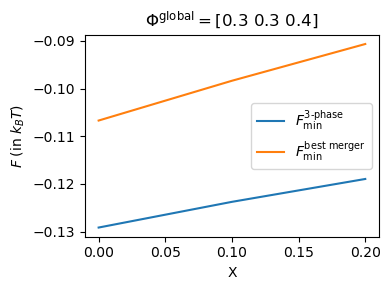

In [78]:
Fs_flory = []
Fs_best_merger = []

for X in tqdm(Xs):
    # Load the Flory's files to get the initial guesses to construct the perturbed state
    input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/"
    input_filename = f"FLORY_3phase_solution.pkl"
    input_file = os.path.join(input_filepath, input_filename)
    
    with gzip.open(input_file, 'rb') as f:
        loaded_data = pickle.load(f)

    Fs_flory.append(loaded_data["flory_free_energy"])

    input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/analysis/X{X:.3f}/mergers/"
    input_filename = f"best_merger.pkl"
    input_file = os.path.join(input_filepath, input_filename)
    with gzip.open(input_file, "rb") as f:
        loaded_data_best = pickle.load(f)
    
    input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/mergers/{loaded_data_best["best_merger_compartment"]}/volume_slices/"
    input_filename = f"eta_m{loaded_data_best["best_merger_slice"]:.3f}.pkl"
    input_file = os.path.join(input_filepath, input_filename)
    with gzip.open(input_file, 'rb') as f:
        loaded_data = pickle.load(f)

    Fs_best_merger.append(np.min(loaded_data["F"]))

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(Xs, Fs_flory, label = r"$F_{\text{min}}^{\text{3-phase}}$")
ax.plot(Xs, Fs_best_merger, label = r"$F_{\text{min}}^{\text{best merger}}$")
ax.set_xlabel("X")
ax.set_ylabel(r"$F \;(\text{in }k_BT)$")
title = r"$\Phi^{\text{global}} = $" + f"{phi_global}" 
plt.legend(loc = "best")
plt.title(title)

fig.tight_layout()

In [66]:
loaded_data_best

{'best_merger_compartment': array([1, 2]),
 'best_merger_slice': 0.6585296912479695,
 'metadata': 'stores the slice in the best merged compartments which returns the lowest free energy possible'}

In [72]:
input_filepath = f"data/withVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/mergers/{loaded_data_best["best_merger_compartment"]}/volume_slices/"
input_filename = f"eta_m{loaded_data_best["best_merger_slice"]:.3f}.pkl"
input_file = os.path.join(input_filepath, input_filename)
with gzip.open(input_file, 'rb') as f:
    loaded_data = pickle.load(f)


In [75]:
loaded_data

{'eta_merged': 0.6585296912479695,
 'phi_1merged': [0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.3642009527393867,
  0.

In [7]:
# Plot the variation in the free energy of the merger and the system as a function of X
def plot_FvsX(Xs):
    Fs_flory = []
    Fs_best_merger = []
    for X in tqdm(Xs):
        # Get the Flory's computation
        input_filepath = f"data/noVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/"
        input_filename = f"FLORY_3phase_solution.pkl"
        input_file = os.path.join(input_filepath, input_filename)
        
        with gzip.open(input_file, 'rb') as f:
            loaded_data = pickle.load(f)

        Fs_flory.append(loaded_data["flory_free_energy"])
        
        # Get the best merger
        input_filepath = f"data/noVolFluctuations/phi_g{phi_global}/analysis/X{X:.3f}"
        input_filename = f"best_merger.pkl"
        if not os.path.exists(input_filepath):
            os.makedirs(input_filepath)
        input_file = os.path.join(input_filepath, input_filename)
        
        with gzip.open(input_file, 'rb') as f:
            loaded_data = pickle.load(f)
        best_merger = loaded_data["best_merger"]
    
        # Load the best merger
        input_filepath = f"data/noVolFluctuations/phi_g{phi_global}/raw/X{X:.3f}/mergers/"
        input_filename = f"{best_merger}.pkl"
        input_file = os.path.join(input_filepath, input_filename)
        
        with gzip.open(input_file, "rb") as f:
            loaded_data = pickle.load(f)
        
        df_loaded = loaded_data["dataframe"]

        min_F_index = np.argmin(df_loaded["F"])
        min_phi1 = df_loaded["phi_1merged"].iloc[min_F_index]
        min_phi2 = df_loaded["phi_2merged"].iloc[min_F_index]
        min_F = df_loaded["F"].iloc[min_F_index]

        Fs_best_merger.append(min_F)

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(Xs, Fs_flory, label = r"$F_{\text{min}}^{\text{3-phase}}$")
    ax.plot(Xs, Fs_best_merger, label = r"$F_{\text{min}}^{\text{best merger}}$")
    ax.set_xlabel("X")
    ax.set_ylabel(r"$F \;(\text{in }k_BT)$")
    title = r"$\Phi^{\text{global}} = $" + f"{phi_global}" 
    plt.legend(loc = "best")
    plt.title(title)
    
    fig.tight_layout()

    
    output_filepath = f"data/noVolFluctuations/phi_g{phi_global}/analysis"
    output_filename = f"F_comparison.png"
    if not os.path.exists(output_filepath):
        os.makedirs(output_filepath)
    output_file = os.path.join(output_filepath, output_filename)
    
    plt.savefig(output_file, dpi =400)
    plt.close()


    F_diff = []
    for _ in list(zip(Fs_flory, Fs_best_merger)):
        F_diff.append(_[1] - _[0])

    fig, ax = plt.subplots(figsize = (4, 3))
    ylabel = r"$F_{\text{min}}^{\text{best merger}} - F_{\text{min}}^{\text{3-phase}}$"
    ax.plot(Xs, F_diff, marker = ".")
    ax.set_xlabel("X")
    ax.set_ylabel(ylabel)
    title = r"$\Phi^{\text{global}} = $" + f"{phi_global}" 
    plt.title(title)
    
    fig.tight_layout()

    output_filepath = f"data/noVolFluctuations/phi_g{phi_global}/analysis"
    output_filename = f"F_diff_comparison.png"
    if not os.path.exists(output_filepath):
        os.makedirs(output_filepath)
    output_file = os.path.join(output_filepath, output_filename)
    
    plt.savefig(output_file, dpi =400)
    plt.close()